<a href="https://colab.research.google.com/github/HaniMLK/RL-Projects/blob/main/SSSSSSSSSS_new_reward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Libraries and Dependencies**

In [2]:
!pip install stable-baselines3[extra]
!pip install gymnasium
!pip install matplotlib
!pip install scipy
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 7.2 MB/s eta 0:00:00


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.patches as patches
from stable_baselines3 import PPO

L = 1.0
A = 0.1
epsilon = 0.25
omega = 2 * np.pi / 10

def velocity_field(x, y, t):
    a = epsilon * np.sin(omega * t)
    b = 1 - 2 * a
    f = a * x**2 + b * x
    df_dx = 2 * a * x + b
    u = -np.pi * A * np.sin(np.pi * f) * np.cos(np.pi * y)
    v = np.pi * A * np.cos(np.pi * f) * np.sin(np.pi * y) * df_dx
    return u, v

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
# old reward scaling including U v x y as obervation

class DoubleGyreEnv(gym.Env):
    def __init__(self, max_steps=1000):
        super(DoubleGyreEnv, self).__init__()

        # Environment bounds
        self.x_min, self.x_max = 0.0, 2.0
        self.y_min, self.y_max = 0.0, 1.0

        # Parameters
        self.reward = 0
        self.energy_used = 0
        self.A = 0.08
        self.epsilon = 0.25
        self.omega = 2 * np.pi / 10

        # Actions: 8 directions + stay
        self.base_action_vectors = np.array([
            [0, 1.0],     # N
            [1.0, 1.0],   # NE
            [1.0, 0],     # E
            [1.0, -1.0],  # SE
            [0, -1.0],    # S
            [-1.0, -1.0], # SW
            [-1.0, 0],    # W
            [-1.0, 1.0],  # NW
            [0.0, 0.0],   # stay
        ])
        for i in range(len(self.base_action_vectors)):
            if i != 8:
                norm = np.linalg.norm(self.base_action_vectors[i])
                self.base_action_vectors[i] /= norm

        self.action_space = spaces.Discrete(len(self.base_action_vectors))

        # 🟢 Observation space now includes [x, y, u, v]
        self.observation_space = spaces.Box(
            low=np.array([self.x_min, self.y_min, -np.inf, -np.inf]),
            high=np.array([self.x_max, self.y_max, np.inf, np.inf]),
            dtype=np.float32
        )

        # Goal and flow centers
        self.goal_radius = 0.03
        self.right_flow_center = np.array([1.5, 0.5])
        self.left_flow_center = np.array([0.5, 0.5])
        self.goal_sphere_radius = 0.1

        # Time and penalties
        self.max_steps = max_steps
        self.movement_penalty = -0.1
        self.movement_penalty_rate = 1
        self.time_penalty = -0.1
        self.time_penalty_rate = 0.01
        self.dt = 0.3
        self.trajectory = []

        self.reset()

    # 🌀 Double gyre velocity field
    def velocity_field(self, x, y, t):
        a = self.epsilon * np.sin(self.omega * t)
        b = 1 - 2 * a
        f = a * x**2 + b * x
        df_dx = 2 * a * x + b
        u = -np.pi * self.A * np.sin(np.pi * f) * np.cos(np.pi * y)
        v = np.pi * self.A * np.cos(np.pi * f) * np.sin(np.pi * y) * df_dx
        return np.array([u, v])

    # 🔵 Helper: check if line segment crosses a sphere
    def _segment_intersects_sphere(self, p1, p2, center, radius):
        d = p2 - p1
        f = p1 - center

        a = np.dot(d, d)
        b = 2 * np.dot(f, d)
        c = np.dot(f, f) - radius**2

        discriminant = b**2 - 4 * a * c
        if discriminant < 0:
            return False
        else:
            discriminant = np.sqrt(discriminant)
            t1 = (-b - discriminant) / (2 * a)
            t2 = (-b + discriminant) / (2 * a)
            return (0 <= t1 <= 1) or (0 <= t2 <= 1)

    def step(self, action):
        self.t += 1
        self.steps += 1

        prev_state = self.state.copy()

        # Get local velocity field
        flow_vec = self.velocity_field(self.state[0], self.state[1], self.t * self.dt)
        flow_magnitude = np.linalg.norm(flow_vec)

        # Compute movement vector
        base_scale = 0.05
        flow_scale_factor =0.4
        action_scale = min(base_scale + flow_scale_factor * flow_magnitude, 0.2)
        action_vec = self.base_action_vectors[action] * action_scale

        # Update position
        self.state = self.state + (action_vec + flow_vec) * self.dt
        self.state = np.clip(self.state, [self.x_min, self.y_min], [self.x_max, self.y_max])

        self.trajectory.append(self.state.copy())

        done = False
        truncated = False
        reward = 0.0

        dist_to_goal = np.linalg.norm(self.state - self.goal_center)
         # Normal distance-based reward
        max_distance = np.linalg.norm([self.x_max - self.x_min, self.y_max - self.y_min])
        normalized_dist = dist_to_goal / max_distance
        reward += normalized_dist - self.previous_distance


        # ✅ Check if we crossed or entered goal sphere
        crossed = self._segment_intersects_sphere(prev_state, self.state, self.goal_center, self.goal_radius)
        if crossed or dist_to_goal <= self.goal_radius:
            reward = 100.0
            done = True
            self.successful_attemp=True
        else:
            if dist_to_goal > self.goal_radius:
                reward += -abs(self.time_penalty_rate * self.time_penalty)

            if action != 8:
                reward += -abs(self.movement_penalty_rate * self.movement_penalty)
                self.energy_used += 0.1

        if self.steps >= self.max_steps:
            truncated = True

        self.reward += reward

        # 🟣 Compute velocity for observation
        flow_vec = self.velocity_field(self.state[0], self.state[1], self.t * self.dt)
        obs = np.array([self.state[0], self.state[1], flow_vec[0], flow_vec[1]], dtype=np.float32)
        self.previous_distance=normalized_dist
        return obs, reward, done, truncated, {}

    def reset(self,run_id=0, seed=None, options=None):
        rng = np.random.default_rng(seed)
        self.run_id=run_id

        self.successful_attemp=False
        self.reward = 0
        self.energy_used = 0
        angle = rng.uniform(0, 2 * np.pi)
        radius = rng.uniform(0, 0.1)
        dx = radius * np.cos(angle)
        dy = radius * np.sin(angle)
        start_x = self.right_flow_center[0] + dx
        start_y = self.right_flow_center[1] + dy

        self.state = np.clip(np.array([start_x, start_y]),
                             [self.x_min, self.y_min],
                             [self.x_max, self.y_max])

        goal_angle = rng.uniform(0, 2 * np.pi)
        goal_radius = rng.uniform(0, self.goal_sphere_radius)
        goal_dx = goal_radius * np.cos(goal_angle)
        goal_dy = goal_radius * np.sin(goal_angle)
        goal_x = self.left_flow_center[0] + goal_dx
        goal_y = self.left_flow_center[1] + goal_dy
        self.goal_center = np.clip(np.array([goal_x, goal_y]),
                                   [self.x_min, self.y_min],
                                   [self.x_max, self.y_max])

        self.t = 0
        self.steps = 0
        self.trajectory = [self.state.copy()]

        # 🟣 Include initial velocity in observation
        flow_vec = self.velocity_field(self.state[0], self.state[1], self.t * self.dt)
        obs = np.array([self.state[0], self.state[1], flow_vec[0], flow_vec[1]], dtype=np.float32)

        dist_to_goal = np.linalg.norm(self.state - self.goal_center)
        max_distance = np.linalg.norm([self.x_max - self.x_min, self.y_max - self.y_min])
        normalized_dist = dist_to_goal / max_distance
        self.previous_distance = normalized_dist
        return obs, {}

    def render(self, mode='human'):
        plt.figure(figsize=(10, 5))

        X, Y = np.meshgrid(np.linspace(self.x_min, self.x_max, 50),
                           np.linspace(self.y_min, self.y_max, 25))
        U = np.zeros_like(X)
        V = np.zeros_like(Y)

        t_plot = 0
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                u, v = self.velocity_field(X[i, j], Y[i, j], t_plot)
                U[i, j] = u
                V[i, j] = v

        norm = np.sqrt(U**2 + V**2)
        norm[norm == 0] = 1
        U_normalized = U / norm
        V_normalized = V / norm
        plt.quiver(X, Y, U_normalized, V_normalized, color='lightgray', alpha=0.7, label='Flow Field')

        traj = np.array(self.trajectory)
        plt.plot(traj[:, 0], traj[:, 1], '-o', label='Agent Path', markersize=3)
        plt.plot(traj[0, 0], traj[0, 1], 'go', label='Start', markersize=8)
        plt.plot(traj[-1, 0], traj[-1, 1], 'ro', label='End', markersize=8)

        goal = patches.Circle(self.goal_center, self.goal_radius, color='cyan', alpha=0.5, label='Goal')
        plt.gca().add_patch(goal)

        sample_circle = patches.Circle(self.right_flow_center, 0.1, color='orange', alpha=0.2,
                                       linestyle='--', linewidth=1.5, fill=True, label='Start Sampling Region')
        plt.gca().add_patch(sample_circle)

        target_sample_circle = patches.Circle(self.left_flow_center, self.goal_sphere_radius, color='purple', alpha=0.2,
                                              linestyle='--', linewidth=1.5, fill=True, label='Target Sampling Region')
        plt.gca().add_patch(target_sample_circle)

        plt.gca().set_aspect('equal')
        plt.xlim(self.x_min, self.x_max)
        plt.ylim(self.y_min, self.y_max)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Double Gyre with Agent Trajectory, Flow Field, and Sampling Regions')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [6]:
# New reward shaping with time in obs
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class DoubleGyreEnv(gym.Env):
    """
    Upgraded Double Gyre for RL:
    - Observation: [x, y, u, v, sin(ωt), cos(ωt)]
    - Reward: stronger progress shaping (positive when moving closer)
    - Switchable action mode: 'discrete' (DQN) or 'continuous' (PPO)
    - Optional domain randomization on A, epsilon per episode
    """
    metadata = {"render_modes": ["human"]}

    def __init__(
        self,
        max_steps=1000,
        action_mode="discrete",        # 'discrete' for DQN, 'continuous' for PPO
        randomize_params=True,         # domain randomization on A, epsilon each episode
        A_base=0.08,
        epsilon_base=0.25,
        omega=2*np.pi/10,
        dt=0.3,
        goal_radius=0.03,
        goal_sphere_radius=0.1,
        k_progress=5.0,                # weight for progress reward  (↑ if you want stronger shaping)
        lambda_time=0.001,             # time penalty per step (outside goal)
        lambda_energy=0.1,             # movement/energy penalty (per step with active action)
        thrust_max=0.2                 # max control magnitude (used in both modes)
    ):
        super().__init__()

        # Domain & time
        self.x_min, self.x_max = 0.0, 2.0
        self.y_min, self.y_max = 0.0, 1.0
        self.dt = dt
        self.omega = omega

        # Base flow params (may be randomized each episode)
        self.A_base = A_base
        self.epsilon_base = epsilon_base
        self.randomize_params = randomize_params

        # Reward parameters
        self.k_progress = k_progress
        self.lambda_time = float(lambda_time)
        self.lambda_energy = float(lambda_energy)

        # Goal & sampling rings
        self.goal_radius = goal_radius
        self.goal_sphere_radius = goal_sphere_radius
        self.right_flow_center = np.array([1.5, 0.5])
        self.left_flow_center  = np.array([0.5, 0.5])

        # Action mode
        assert action_mode in ("discrete", "continuous")
        self.action_mode = action_mode
        self.thrust_max = float(thrust_max)

        if self.action_mode == "discrete":
            # 8 directions + stay (unit vectors), scaled inside step()
            self.base_action_vectors = np.array([
                [0,  1.0],  [1.0,  1.0],  [1.0,  0],
                [1.0,-1.0], [0,  -1.0],  [-1.0,-1.0],
                [-1.0, 0],  [-1.0, 1.0], [0.0,  0.0]
            ], dtype=np.float32)
            for i in range(8):
                self.base_action_vectors[i] /= np.linalg.norm(self.base_action_vectors[i])
            self.action_space = spaces.Discrete(9)
        else:
            # Continuous 2D thrust in [-1, 1]^2 (scaled by thrust_max)
            self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(2,), dtype=np.float32)

        # Observation: [x, y, u, v, sin(ωt), cos(ωt)]
        low  = np.array([self.x_min, self.y_min, -np.inf, -np.inf, -1.0, -1.0], dtype=np.float32)
        high = np.array([self.x_max, self.y_max,  np.inf,  np.inf,  1.0,  1.0], dtype=np.float32)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)

        # Episode bookkeeping
        self.max_steps = max_steps
        self.reset()

    # --- Double Gyre flow (time-dependent) ---
    def flow_params(self):
        return self.A, self.epsilon, self.omega

    def velocity_field(self, x, y, t):
        A, eps, om = self.flow_params()
        a = eps * np.sin(om * t)
        b = 1.0 - 2.0*a
        f = a*x*x + b*x
        df_dx = 2.0*a*x + b
        u = -np.pi * A * np.sin(np.pi * f) * np.cos(np.pi * y)
        v =  np.pi * A * np.cos(np.pi * f) * np.sin(np.pi * y) * df_dx
        return np.array([u, v], dtype=np.float32)

    def _segment_intersects_sphere(self, p1, p2, center, radius):
        d = p2 - p1
        f = p1 - center
        a = float(np.dot(d, d))
        b = 2.0 * float(np.dot(f, d))
        c = float(np.dot(f, f)) - radius**2
        disc = b*b - 4*a*c
        if disc < 0.0:
            return False
        s = np.sqrt(disc)
        t1 = (-b - s) / (2*a)
        t2 = (-b + s) / (2*a)
        return (0.0 <= t1 <= 1.0) or (0.0 <= t2 <= 1.0)

    def _obs(self):
        flow = self.velocity_field(self.state[0], self.state[1], self.t * self.dt)
        phase_sin = np.sin(self.omega * self.t * self.dt)
        phase_cos = np.cos(self.omega * self.t * self.dt)
        return np.array([self.state[0], self.state[1], flow[0], flow[1], phase_sin, phase_cos], dtype=np.float32)

    def step(self, action):
        self.t += 1
        self.steps += 1

        prev_pos = self.state.copy()
        flow_vec = self.velocity_field(self.state[0], self.state[1], self.t * self.dt)
        flow_mag = float(np.linalg.norm(flow_vec))

        # --- control vector ---
        if self.action_mode == "discrete":
            # scale with local flow magnitude (capped)
            base_scale = 0.05
            flow_scale_factor = 0.4
            action_scale = min(base_scale + flow_scale_factor * flow_mag, self.thrust_max)
            action_vec = self.base_action_vectors[action] * action_scale
            moved = (action != 8)
            energy_factor = 1.0 if moved else 0.0
        else:
            # continuous thrust in [-1,1]^2 → scale to thrust_max and clip by L2
            a = np.asarray(action, dtype=np.float32)
            a = np.clip(a, -1.0, 1.0)
            if np.linalg.norm(a) > 1.0:
                a = a / (np.linalg.norm(a) + 1e-8)
            action_vec = a * self.thrust_max
            energy_factor = float(np.linalg.norm(a) > 1e-6)

        # Euler step + clipping
        self.state = self.state + (action_vec + flow_vec) * self.dt
        self.state = np.clip(self.state, [self.x_min, self.y_min], [self.x_max, self.y_max])
        self.trajectory.append(self.state.copy())

        # --- rewards ---
        # normalized distances
        d_prev = float(np.linalg.norm(prev_pos - self.goal_center))
        d_curr = float(np.linalg.norm(self.state   - self.goal_center))
        d_max  = float(np.linalg.norm([self.x_max - self.x_min, self.y_max - self.y_min]))
        d_prev_n = d_prev / d_max
        d_curr_n = d_curr / d_max

        # progress (positive when getting closer)
        progress = d_prev_n - d_curr_n
        reward = self.k_progress * progress

        done = False
        truncated = False

        # goal check (cross or inside)
        crossed = self._segment_intersects_sphere(prev_pos, self.state, self.goal_center, self.goal_radius)
        if crossed or (d_curr <= self.goal_radius):
            reward = 100.0
            done = True
            self.successful_attempt = True
        else:
            # time penalty outside goal
            reward -= self.lambda_time
            # energy/movement penalty
            reward -= self.lambda_energy * energy_factor

        if self.steps >= self.max_steps:
            truncated = True

        self.total_return += reward
        self.energy_used  += 0.1 * energy_factor  # bookkeeping (not part of reward except via penalty above)

        info = {
            "success": bool(done),
            "progress": progress,
            "dist_norm": d_curr_n
        }
        return self._obs(), float(reward), bool(done), bool(truncated), info

    def reset(self, run_id=0, seed=None, options=None):
        rng = np.random.default_rng(seed)
        self.run_id = run_id

        # (optional) domain randomization on A, epsilon each episode
        if self.randomize_params:
            self.A = self.A_base * rng.uniform(0.9, 1.1)
            self.epsilon = self.epsilon_base * rng.uniform(0.9, 1.1)
        else:
            self.A = self.A_base
            self.epsilon = self.epsilon_base

        # start near right gyre
        angle = rng.uniform(0, 2*np.pi)
        radius = rng.uniform(0, 0.1)
        start = self.right_flow_center + radius * np.array([np.cos(angle), np.sin(angle)])
        self.state = np.clip(start, [self.x_min, self.y_min], [self.x_max, self.y_max])

        # goal near left gyre
        goal_angle = rng.uniform(0, 2*np.pi)
        goal_radius = rng.uniform(0, self.goal_sphere_radius)
        goal = self.left_flow_center + goal_radius * np.array([np.cos(goal_angle), np.sin(goal_angle)])
        self.goal_center = np.clip(goal, [self.x_min, self.y_min], [self.x_max, self.y_max])

        # time & logs
        self.t = 0
        self.steps = 0
        self.trajectory = [self.state.copy()]
        self.total_return = 0.0
        self.energy_used = 0.0
        self.successful_attempt = False

        return self._obs(), {}


# DQN

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/tmp/ipython-input-1239246780.py:108: RuntimeWarning: invalid value encountered in scalar divide
  t1 = (-b - s) / (2*a)
/tmp/ipython-input-1239246780.py:109: RuntimeWarning: invalid value encountered in scalar divide
  t2 = (-b + s) / (2*a)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00136  |
|    n_updates        | 105243   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 487      |
|    ep_rew_mean      | 68.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 760      |
|    fps              | 850      |
|    time_elapsed     | 496      |
|    total_timesteps  | 422484   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0014   |
|    n_updates        | 105595   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 497      |
|    ep_rew_mean      | 68.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 764      |
|   

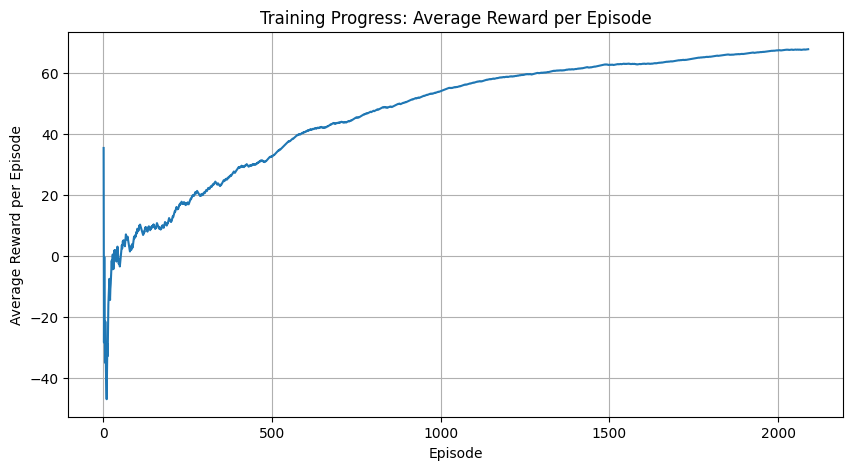

In [7]:
# DQN
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback

class EpisodeRewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_count = 0

    def _on_step(self) -> bool:
        done = self.locals["dones"][0]
        if done:
            info = self.locals["infos"][0]
            # Get episode reward from info dict
            ep_rew = info.get("episode", {}).get("r")
            ep_len = info.get("episode", {}).get("l")
            if ep_rew is not None:
                self.episode_rewards.append(ep_rew)
                self.episode_lengths.append(ep_len)
                self.episode_count += 1
        return True

# env = DoubleGyreEnv()
env = DoubleGyreEnv(action_mode="discrete", randomize_params=True)
check_env(env)
model = DQN("MlpPolicy", env, verbose=1, buffer_size=1000000, batch_size=64)

callback = EpisodeRewardCallback()
model.learn(total_timesteps=1000000, callback=callback)
model.save("modelgyr")

# --- Plot average reward per episode ---
rewards = np.array(callback.episode_rewards)
episodes = np.arange(1, len(rewards) + 1)
avg_rewards = np.cumsum(rewards) / episodes

plt.figure(figsize=(10, 5))
plt.plot(episodes, avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Average Reward per Episode")
plt.title("Training Progress: Average Reward per Episode")
plt.grid(True)
plt.show()

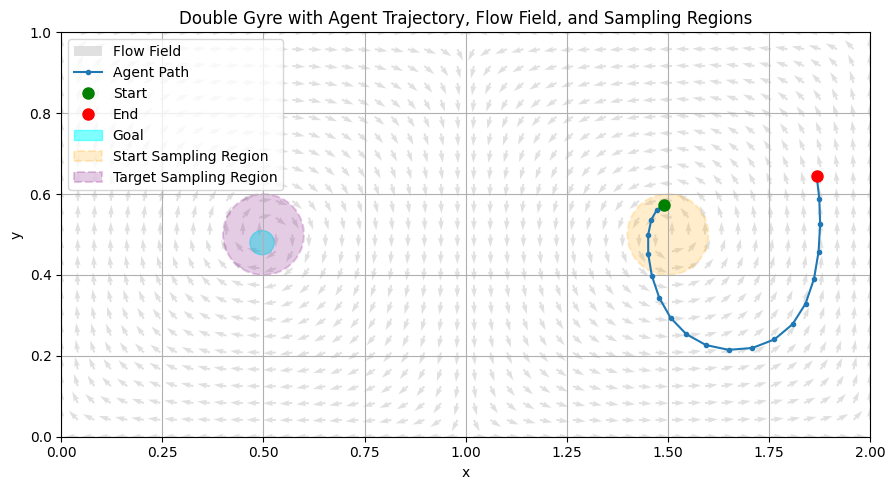

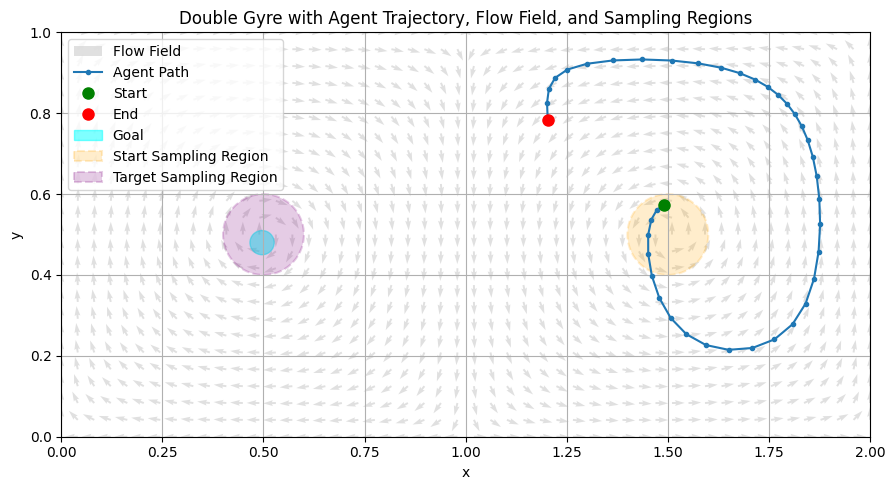

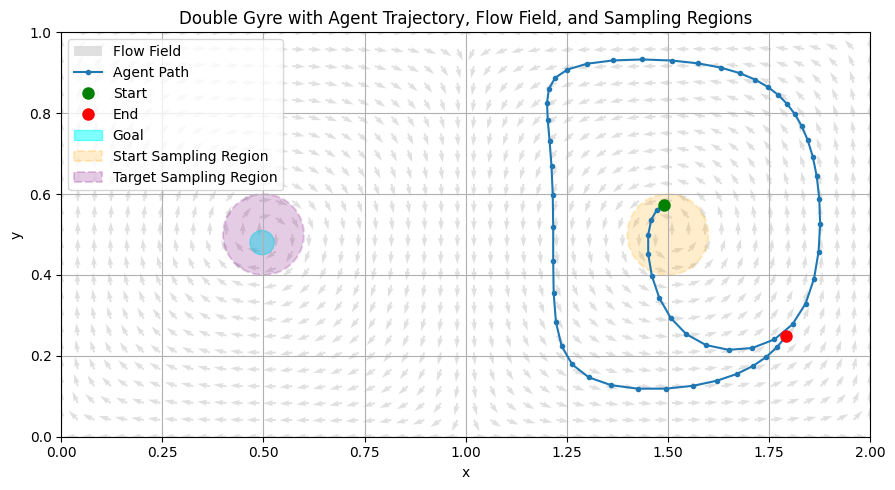

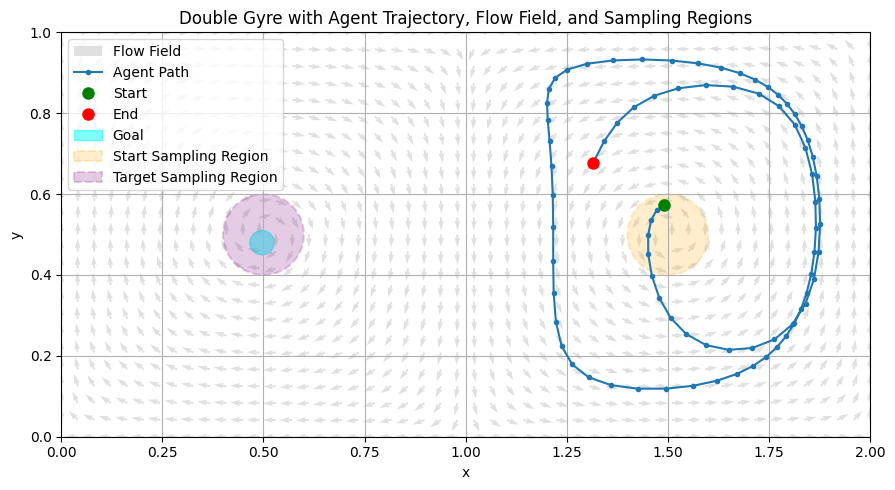

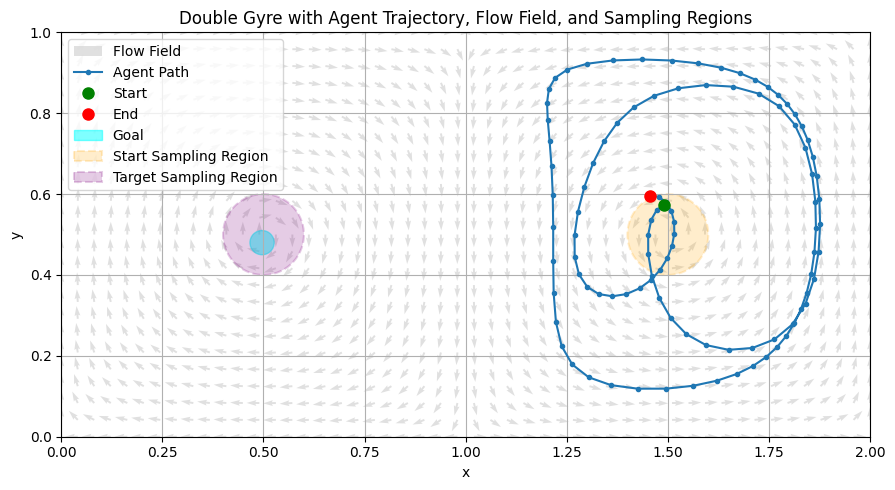

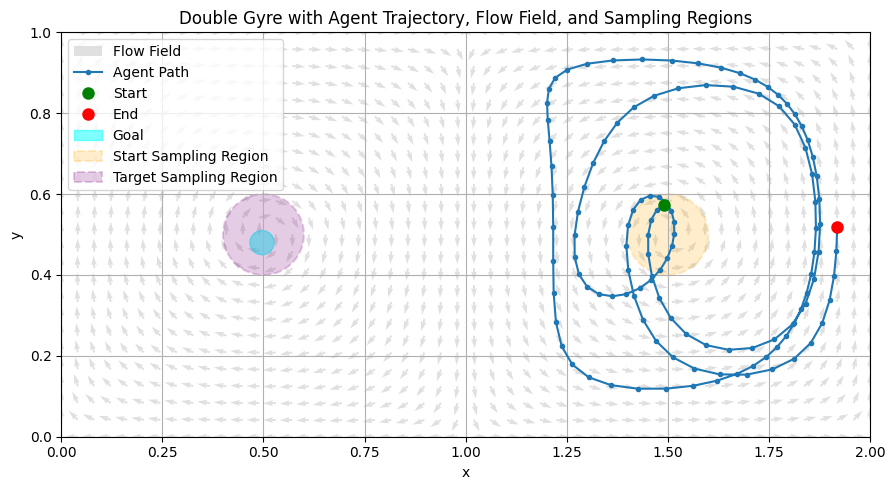

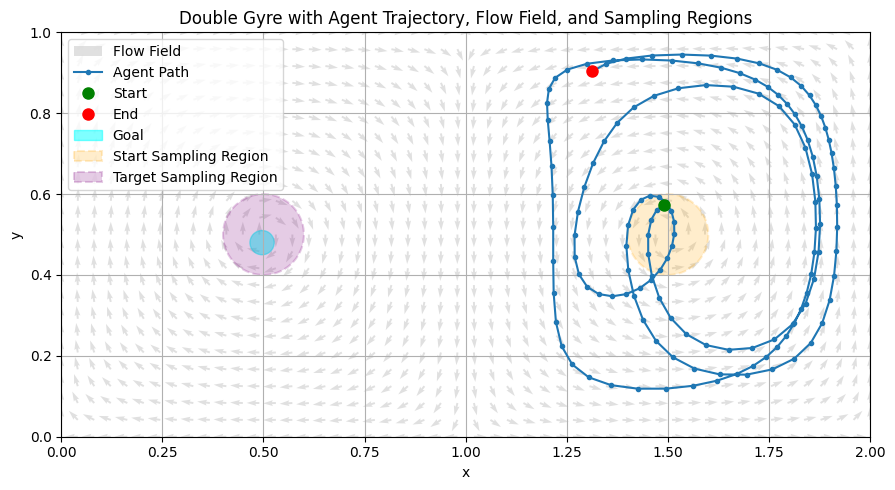

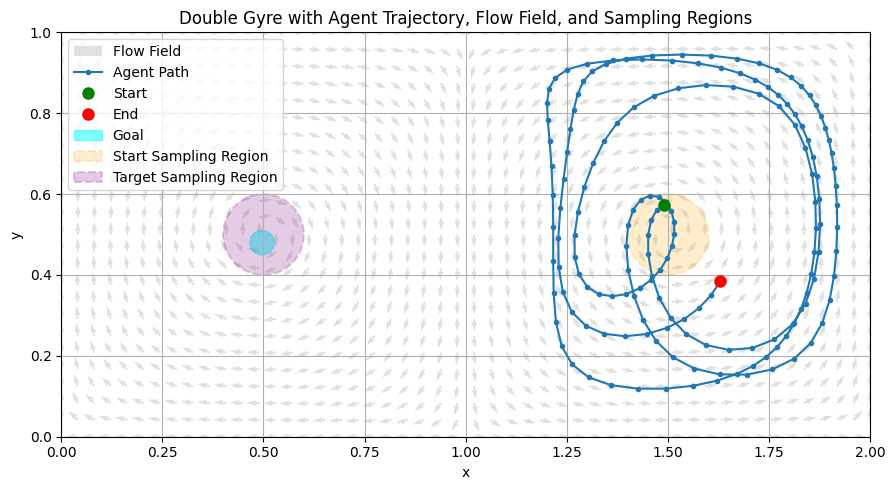

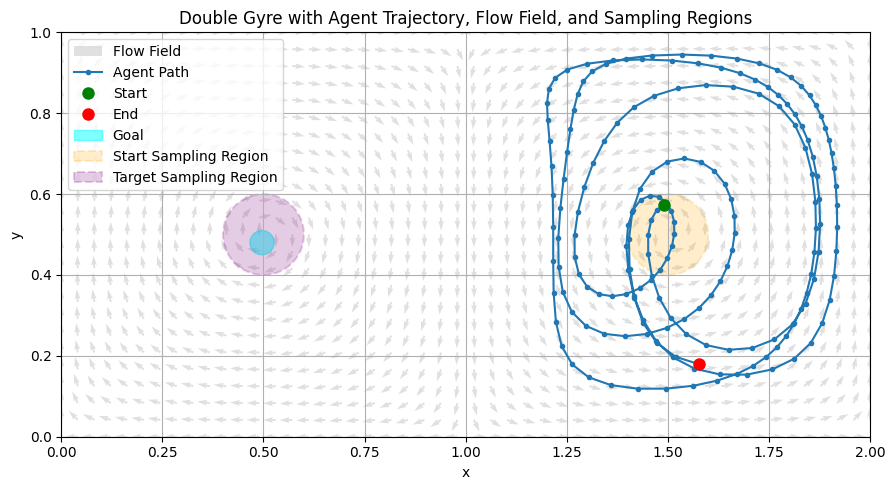

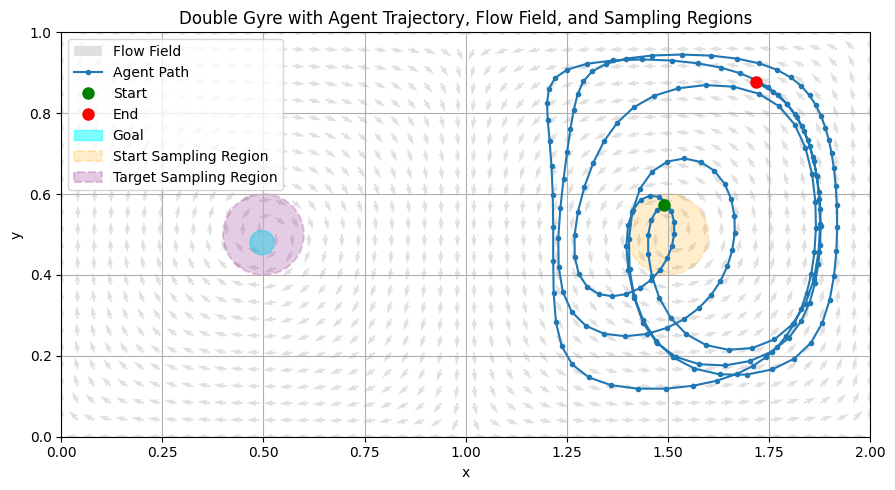

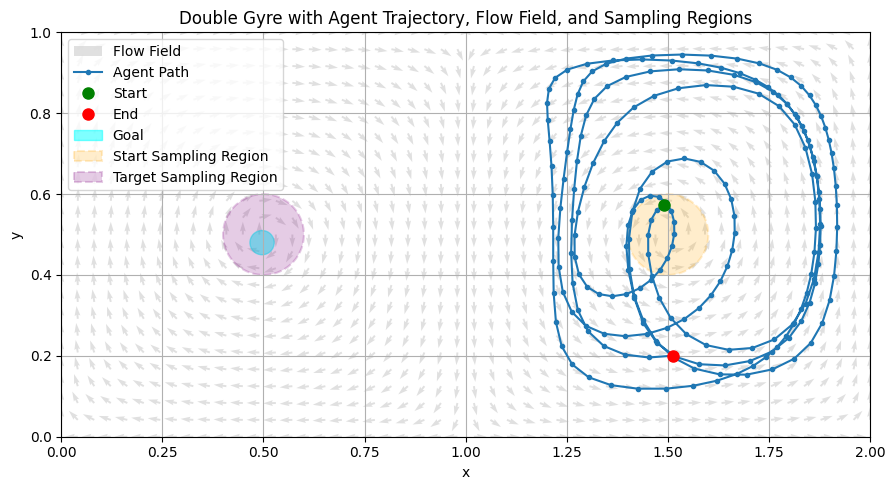

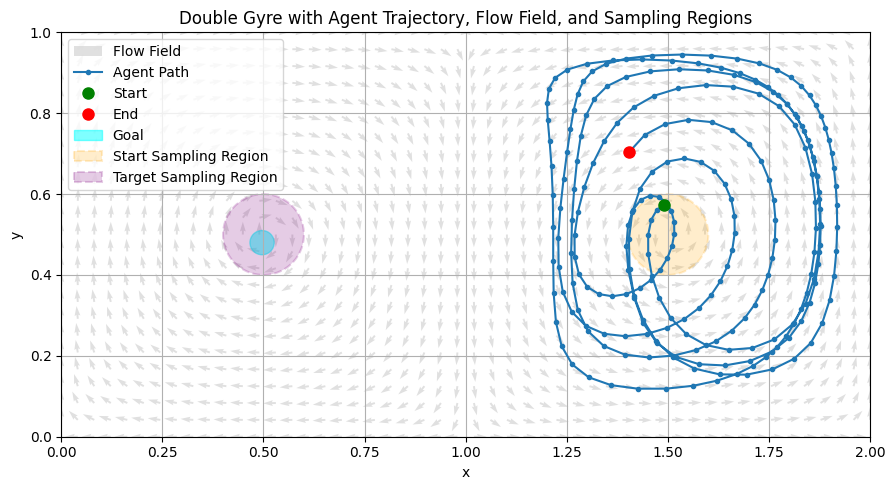

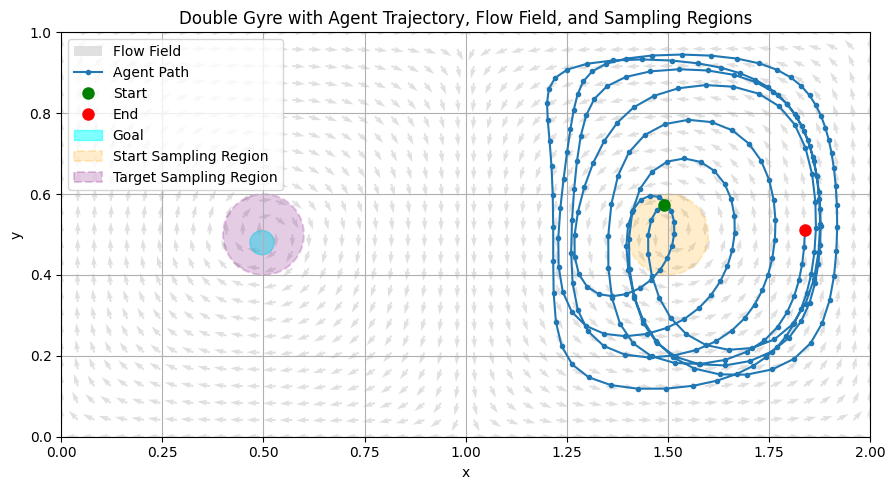

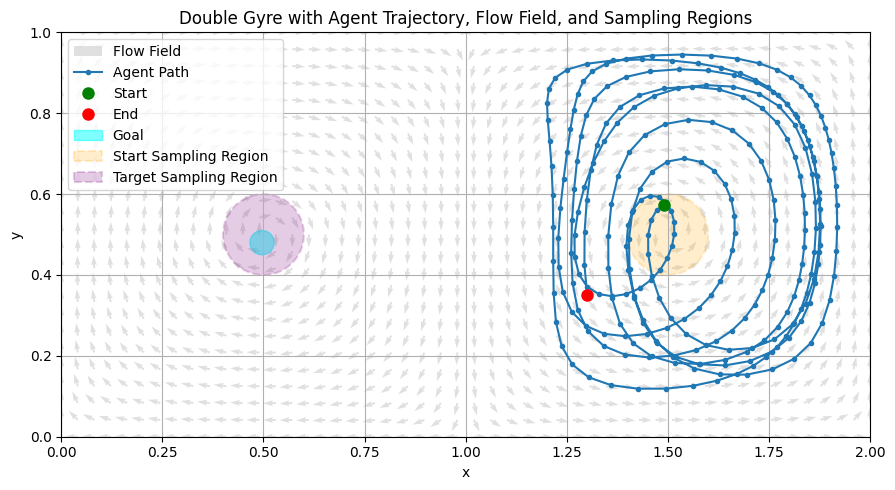

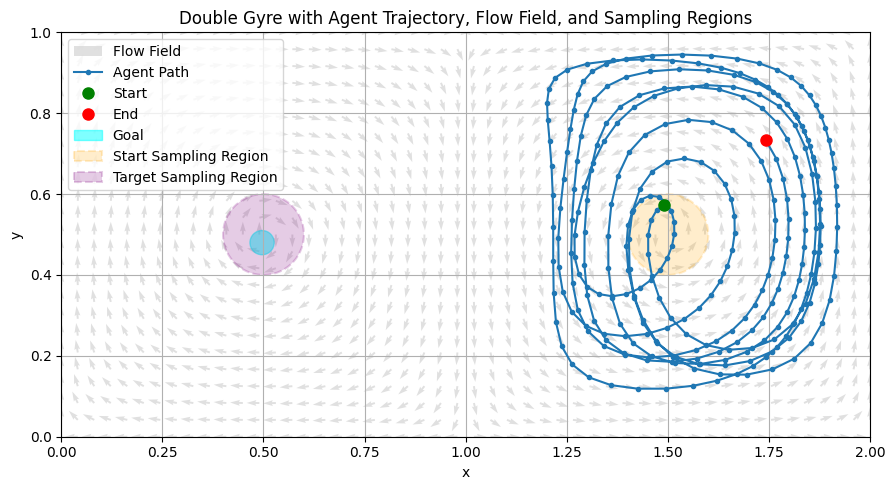

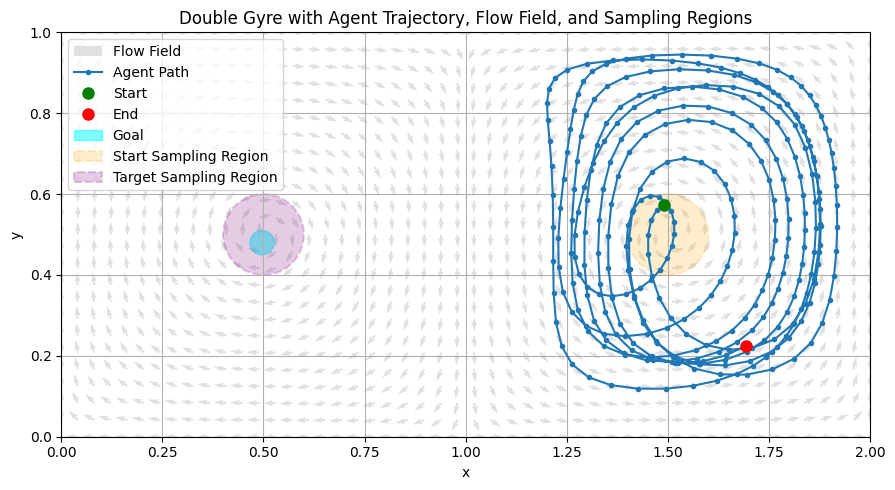

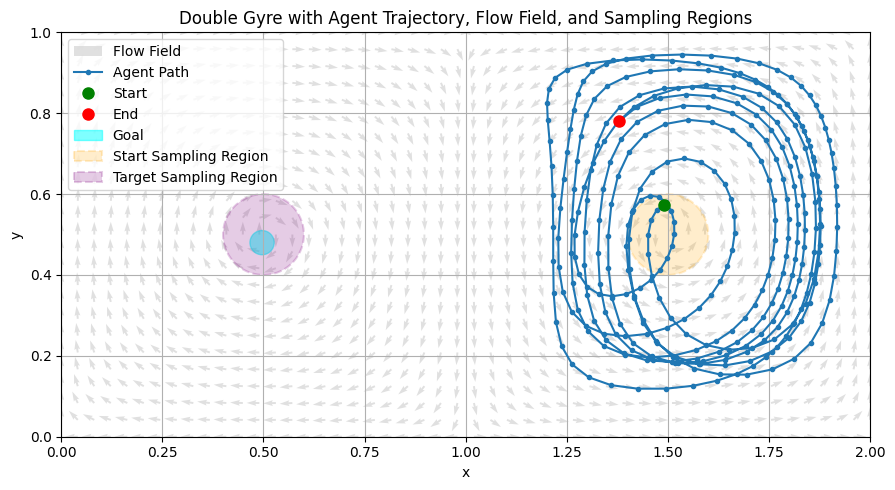

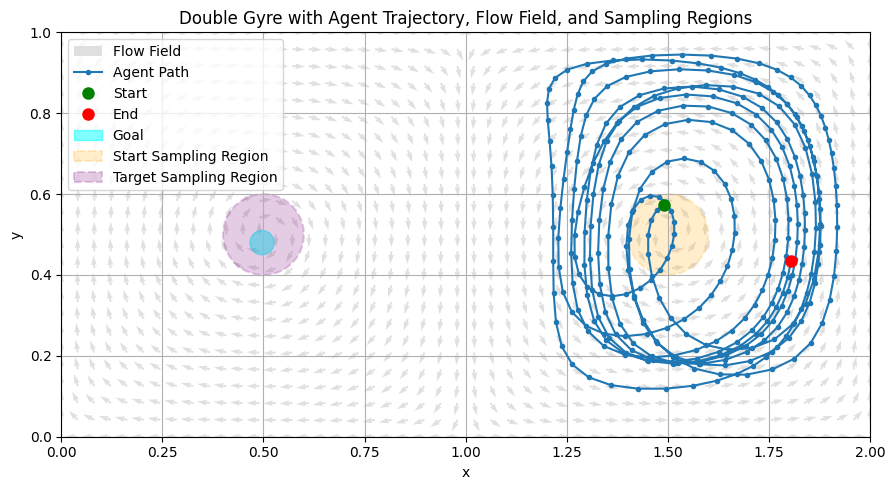

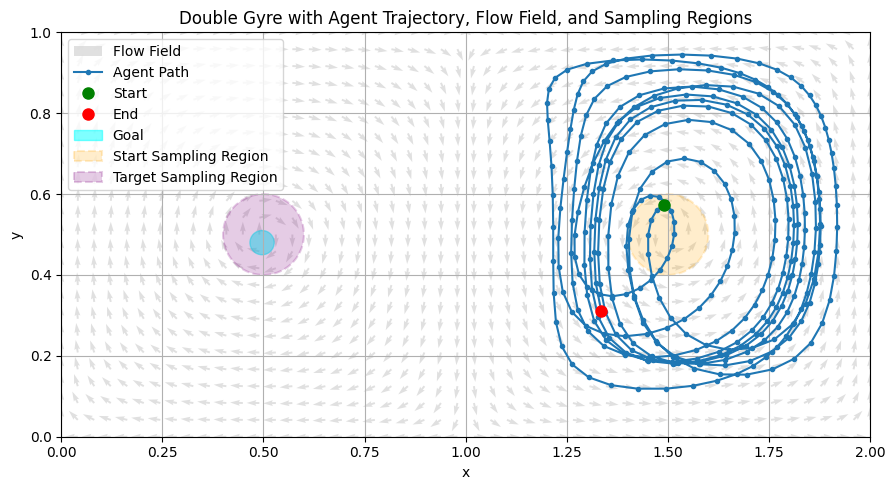

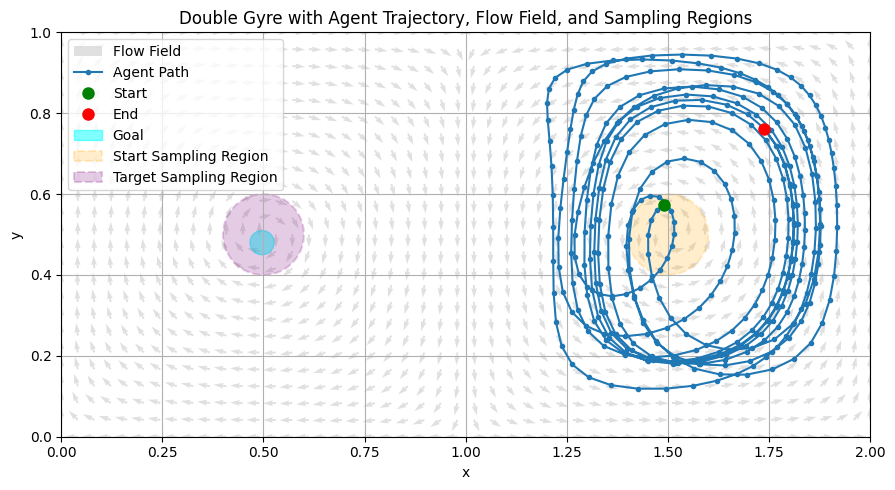

KeyboardInterrupt: 

In [6]:
env = DoubleGyreEnv()
check_env(env)
obs, _ = env.reset()
done = False
env.history = [obs[:2]]
foo=0
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    env.history.append(obs[:2])
    if(len(env.history)%20)==0:
        env.render()
    # plt.legend()
    foo+=1
    # if foo>20:
    #     break

The best Trajectory was for env number:19 it succeded in 57 steps and gainded reward of  102.25962834629519 and used 0.2 energy!!
Success Rate: 74.00% (37/50 trajectories reached the goal)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


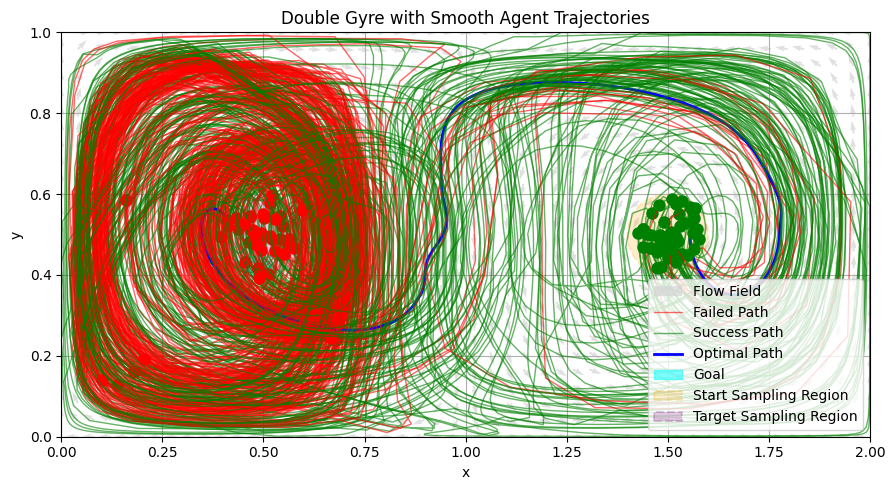

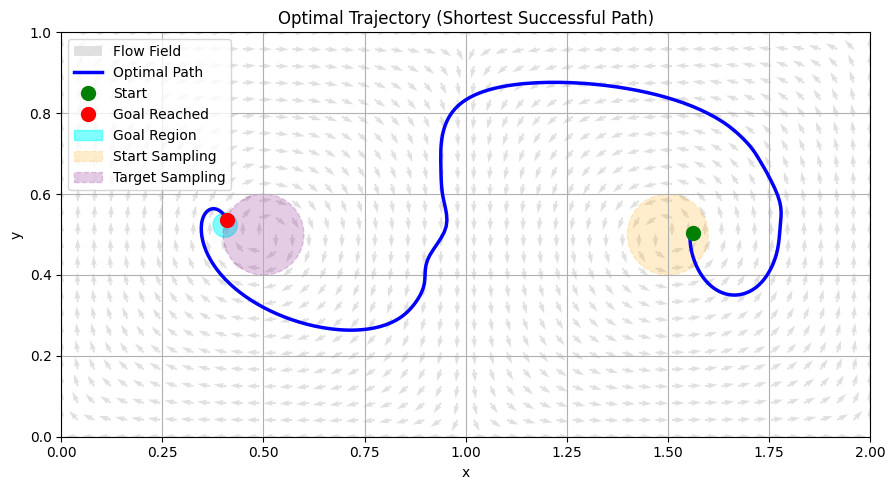

In [11]:
from scipy.interpolate import make_interp_spline

def plot_trajectories(envs, mode='human'):
    import matplotlib.pyplot as plt
    from scipy.interpolate import make_interp_spline
    import matplotlib.patches as patches
    import numpy as np

    plt.figure(figsize=(10, 5))
    env = envs[0]
    x_min, x_max = env.x_min, env.x_max
    y_min, y_max = env.y_min, env.y_max

    X, Y = np.meshgrid(np.linspace(x_min, x_max, 50),
                       np.linspace(y_min, y_max, 25))
    U = np.zeros_like(X)
    V = np.zeros_like(Y)

    t_plot = 0
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            u, v = env.velocity_field(X[i, j], Y[i, j], t_plot)
            U[i, j] = u
            V[i, j] = v

    norm = np.sqrt(U**2 + V**2)
    norm[norm == 0] = 1
    U_normalized = U / norm
    V_normalized = V / norm
    plt.quiver(X, Y, U_normalized, V_normalized, color='lightgray', alpha=0.7, label='Flow Field')

    success_count = 0
    total_traj = len(envs)

    # Determine successful and optimal environments
    successful_envs = []
    for env in envs:
        if env.successful_attempt:
            successful_envs.append(env)
            success_count+=1

    optimal_env = max(successful_envs, key=lambda e: e.total_return) if successful_envs else None

    for env in envs:
        traj = np.array(env.trajectory)
        # Determine color and label
        if env is optimal_env:
            print(f"The best Trajectory was for env number:{env.run_id} it succeded in {env.t} steps and gainded reward of  {env.total_return} and used {env.energy_used} energy!!")
            color = 'blue'
            label = 'Optimal Path'
            linewidth = 2
            alpha = 1.0
        else:
            color = 'green' if env.successful_attempt else 'red'
            label = 'Success Path' if env.successful_attempt else 'Failed Path'
            linewidth = 1
            alpha = 0.6

        # Smooth or straight plot
        if len(traj) > 3:
            t = np.linspace(0, 1, len(traj))
            t_fine = np.linspace(0, 1, 300)
            spl_x = make_interp_spline(t, traj[:, 0], k=3)
            spl_y = make_interp_spline(t, traj[:, 1], k=3)
            x_smooth = spl_x(t_fine)
            y_smooth = spl_y(t_fine)
            plt.plot(x_smooth, y_smooth, '-', color=color, label=label, linewidth=linewidth, alpha=alpha)
        else:
            plt.plot(traj[:, 0], traj[:, 1], '-o', color=color, label=label, markersize=3, linewidth=linewidth, alpha=alpha)

        plt.plot(traj[0, 0], traj[0, 1], 'go', markersize=8)
        plt.plot(traj[-1, 0], traj[-1, 1], 'ro', markersize=8)

    success_rate = (success_count / total_traj * 100) if total_traj > 0 else 0
    print(f"Success Rate: {success_rate:.2f}% ({success_count}/{total_traj} trajectories reached the goal)")

    goal = patches.Circle(env.goal_center, env.goal_radius, color='cyan', alpha=0.5, label='Goal')
    plt.gca().add_patch(goal)
    sample_circle = patches.Circle(env.right_flow_center, 0.1, color='orange', alpha=0.2, linestyle='--', linewidth=1.5, fill=True, label='Start Sampling Region')
    plt.gca().add_patch(sample_circle)
    target_sample_circle = patches.Circle(env.left_flow_center, env.goal_sphere_radius, color='purple', alpha=0.2, linestyle='--', linewidth=1.5, fill=True, label='Target Sampling Region')
    plt.gca().add_patch(target_sample_circle)

    plt.gca().set_aspect('equal')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Double Gyre with Smooth Agent Trajectories')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.tight_layout()

    if mode == 'human':
        plt.show()

    # === NEW PLOT: Optimal trajectory only ===
    if optimal_env is not None:
        traj = np.array(optimal_env.trajectory)

        plt.figure(figsize=(10, 5))
        X, Y = np.meshgrid(np.linspace(x_min, x_max, 50),
                           np.linspace(y_min, y_max, 25))
        U = np.zeros_like(X)
        V = np.zeros_like(Y)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                u, v = optimal_env.velocity_field(X[i, j], Y[i, j], t_plot)
                U[i, j] = u
                V[i, j] = v
        norm = np.sqrt(U**2 + V**2)
        norm[norm == 0] = 1
        plt.quiver(X, Y, U / norm, V / norm, color='lightgray', alpha=0.7, label='Flow Field')

        t = np.linspace(0, 1, len(traj))
        t_fine = np.linspace(0, 1, 300)
        spl_x = make_interp_spline(t, traj[:, 0], k=3)
        spl_y = make_interp_spline(t, traj[:, 1], k=3)
        x_smooth = spl_x(t_fine)
        y_smooth = spl_y(t_fine)

        plt.plot(x_smooth, y_smooth, '-', color='blue', linewidth=2.5, label='Optimal Path')
        plt.plot(traj[0, 0], traj[0, 1], 'go', markersize=10, label='Start')
        plt.plot(traj[-1, 0], traj[-1, 1], 'ro', markersize=10, label='Goal Reached')

        goal = patches.Circle(optimal_env.goal_center, optimal_env.goal_radius, color='cyan', alpha=0.5, label='Goal Region')
        plt.gca().add_patch(goal)
        sample_circle = patches.Circle(optimal_env.right_flow_center, 0.1, color='orange', alpha=0.2, linestyle='--', label='Start Sampling')
        plt.gca().add_patch(sample_circle)
        target_sample_circle = patches.Circle(optimal_env.left_flow_center, optimal_env.goal_sphere_radius, color='purple', alpha=0.2, linestyle='--', label='Target Sampling')
        plt.gca().add_patch(target_sample_circle)

        plt.gca().set_aspect('equal')
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Optimal Trajectory (Shortest Successful Path)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if mode == 'human':
            plt.show()

envs=[]
for i in range(50):
    env = DoubleGyreEnv()
    check_env(env)
    obs, _ = env.reset(run_id=i)
    done = False
    env.history = [obs[:2]]
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        env.history.append(obs[:2])
    envs.append(env)
plot_trajectories(envs)

In [ ]:
# compatible with old reward
from scipy.interpolate import make_interp_spline

def plot_trajectories(envs, mode='human'):
    import matplotlib.pyplot as plt
    from scipy.interpolate import make_interp_spline
    import matplotlib.patches as patches
    import numpy as np

    plt.figure(figsize=(10, 5))
    env = envs[0]
    x_min, x_max = env.x_min, env.x_max
    y_min, y_max = env.y_min, env.y_max

    X, Y = np.meshgrid(np.linspace(x_min, x_max, 50),
                       np.linspace(y_min, y_max, 25))
    U = np.zeros_like(X)
    V = np.zeros_like(Y)

    t_plot = 0
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            u, v = env.velocity_field(X[i, j], Y[i, j], t_plot)
            U[i, j] = u
            V[i, j] = v

    norm = np.sqrt(U**2 + V**2)
    norm[norm == 0] = 1
    U_normalized = U / norm
    V_normalized = V / norm
    plt.quiver(X, Y, U_normalized, V_normalized, color='lightgray', alpha=0.7, label='Flow Field')

    success_count = 0
    total_traj = len(envs)

    # Determine successful and optimal environments
    successful_envs = []
    for env in envs:
        if env.successful_attemp:
            successful_envs.append(env)
            success_count+=1

    optimal_env = max(successful_envs, key=lambda e: e.total_return) if successful_envs else None

    for env in envs:
        traj = np.array(env.trajectory)
        # Determine color and label
        if env is optimal_env:
            print(f"The best Trajectory was for env number:{env.run_id} it succeded in {env.t} steps and gainded reward of  {env.total_return} and used {env.energy_used} energy!!")
            color = 'blue'
            label = 'Optimal Path'
            linewidth = 2
            alpha = 1.0
        else:
            color = 'green' if env.successful_attemp else 'red'
            label = 'Success Path' if env.successful_attemp else 'Failed Path'
            linewidth = 1
            alpha = 0.6

        # Smooth or straight plot
        if len(traj) > 3:
            t = np.linspace(0, 1, len(traj))
            t_fine = np.linspace(0, 1, 300)
            spl_x = make_interp_spline(t, traj[:, 0], k=3)
            spl_y = make_interp_spline(t, traj[:, 1], k=3)
            x_smooth = spl_x(t_fine)
            y_smooth = spl_y(t_fine)
            plt.plot(x_smooth, y_smooth, '-', color=color, label=label, linewidth=linewidth, alpha=alpha)
        else:
            plt.plot(traj[:, 0], traj[:, 1], '-o', color=color, label=label, markersize=3, linewidth=linewidth, alpha=alpha)

        plt.plot(traj[0, 0], traj[0, 1], 'go', markersize=8)
        plt.plot(traj[-1, 0], traj[-1, 1], 'ro', markersize=8)

    success_rate = (success_count / total_traj * 100) if total_traj > 0 else 0
    print(f"Success Rate: {success_rate:.2f}% ({success_count}/{total_traj} trajectories reached the goal)")

    goal = patches.Circle(env.goal_center, env.goal_radius, color='cyan', alpha=0.5, label='Goal')
    plt.gca().add_patch(goal)
    sample_circle = patches.Circle(env.right_flow_center, 0.1, color='orange', alpha=0.2, linestyle='--', linewidth=1.5, fill=True, label='Start Sampling Region')
    plt.gca().add_patch(sample_circle)
    target_sample_circle = patches.Circle(env.left_flow_center, env.goal_sphere_radius, color='purple', alpha=0.2, linestyle='--', linewidth=1.5, fill=True, label='Target Sampling Region')
    plt.gca().add_patch(target_sample_circle)

    plt.gca().set_aspect('equal')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Double Gyre with Smooth Agent Trajectories')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.tight_layout()

    if mode == 'human':
        plt.show()

    # === NEW PLOT: Optimal trajectory only ===
    if optimal_env is not None:
        traj = np.array(optimal_env.trajectory)

        plt.figure(figsize=(10, 5))
        X, Y = np.meshgrid(np.linspace(x_min, x_max, 50),
                           np.linspace(y_min, y_max, 25))
        U = np.zeros_like(X)
        V = np.zeros_like(Y)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                u, v = optimal_env.velocity_field(X[i, j], Y[i, j], t_plot)
                U[i, j] = u
                V[i, j] = v
        norm = np.sqrt(U**2 + V**2)
        norm[norm == 0] = 1
        plt.quiver(X, Y, U / norm, V / norm, color='lightgray', alpha=0.7, label='Flow Field')

        t = np.linspace(0, 1, len(traj))
        t_fine = np.linspace(0, 1, 300)
        spl_x = make_interp_spline(t, traj[:, 0], k=3)
        spl_y = make_interp_spline(t, traj[:, 1], k=3)
        x_smooth = spl_x(t_fine)
        y_smooth = spl_y(t_fine)

        plt.plot(x_smooth, y_smooth, '-', color='blue', linewidth=2.5, label='Optimal Path')
        plt.plot(traj[0, 0], traj[0, 1], 'go', markersize=10, label='Start')
        plt.plot(traj[-1, 0], traj[-1, 1], 'ro', markersize=10, label='Goal Reached')

        goal = patches.Circle(optimal_env.goal_center, optimal_env.goal_radius, color='cyan', alpha=0.5, label='Goal Region')
        plt.gca().add_patch(goal)
        sample_circle = patches.Circle(optimal_env.right_flow_center, 0.1, color='orange', alpha=0.2, linestyle='--', label='Start Sampling')
        plt.gca().add_patch(sample_circle)
        target_sample_circle = patches.Circle(optimal_env.left_flow_center, optimal_env.goal_sphere_radius, color='purple', alpha=0.2, linestyle='--', label='Target Sampling')
        plt.gca().add_patch(target_sample_circle)

        plt.gca().set_aspect('equal')
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Optimal Trajectory (Shortest Successful Path)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if mode == 'human':
            plt.show()

envs=[]
for i in range(50):
    env = DoubleGyreEnv()
    check_env(env)
    obs, _ = env.reset(run_id=i)
    done = False
    env.history = [obs[:2]]
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        env.history.append(obs[:2])
    envs.append(env)
plot_trajectories(envs)

The best Trajectory was for env number:0 it succeded in 62 steps and gainded reward of  102.25305434071197 and used 0.30000000000000004 energy!!
Success Rate: 75.40% (754/1000 trajectories reached the goal)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


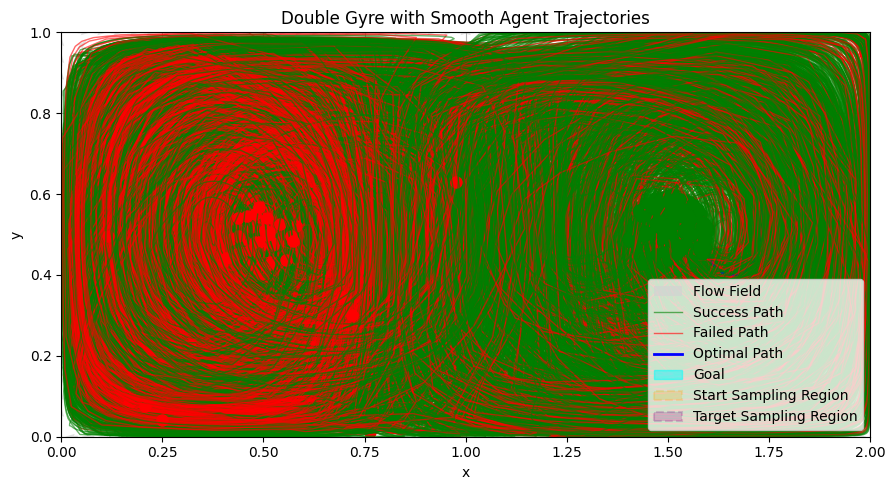

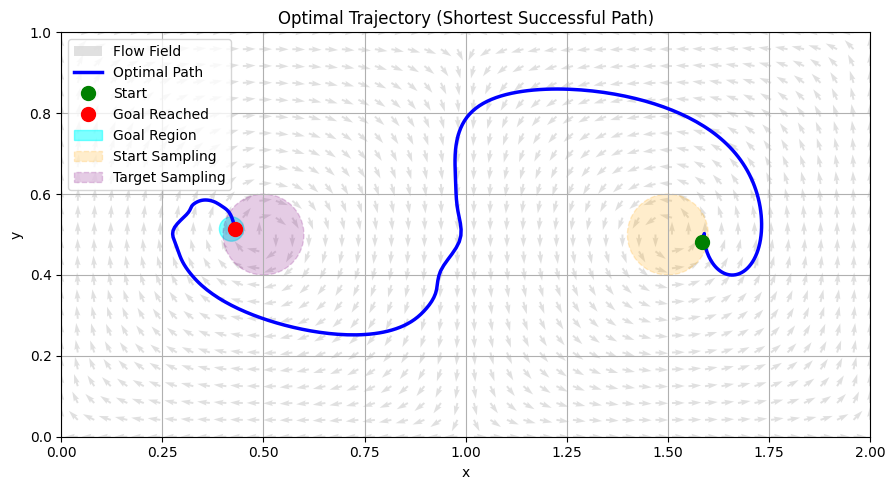

In [12]:
envs=[]
for i in range(1000):
    env = DoubleGyreEnv()
    check_env(env)
    obs, _ = env.reset()
    done = False
    env.history = [obs[:2]]
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        env.history.append(obs[:2])
    envs.append(env)
plot_trajectories(envs)

In [14]:
import numpy as np

def path_length(traj):
    d = np.diff(np.array(traj), axis=0)
    return float(np.sum(np.linalg.norm(d, axis=1)))

def summarize(envs):
    succ = [e for e in envs if getattr(e, "successful_attemp", False)]
    fail = [e for e in envs if not getattr(e, "successful_attemp", False)]
    sr   = 100.0 * len(succ) / max(1, len(envs))
    steps = [e.t for e in succ]
    paths = [path_length(e.trajectory) for e in succ]
    energy= [e.energy_used for e in succ]
    return {
        "success_rate_%": sr,
        "steps_mean±std": (np.mean(steps), np.std(steps)),
        "path_len_mean±std": (np.mean(paths), np.std(paths)),
        "energy_mean±std": (np.mean(energy), np.std(energy)),
        "fail_count": len(fail)
    }

print("DQN test summary:", summarize(envs))  # use your 1000-episode list


DQN test summary: {'success_rate_%': 0.0, 'steps_mean±std': (np.float64(nan), np.float64(nan)), 'path_len_mean±std': (np.float64(nan), np.float64(nan)), 'energy_mean±std': (np.float64(nan), np.float64(nan)), 'fail_count': 1000}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# PPO Method

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/tmp/ipython-input-1239246780.py:108: RuntimeWarning: invalid value encountered in scalar divide
  t1 = (-b - s) / (2*a)
/tmp/ipython-input-1239246780.py:109: RuntimeWarning: invalid value encountered in scalar divide
  t2 = (-b + s) / (2*a)


Streaming output truncated to the last 5000 lines.
|    loss                 | 21.9        |
|    n_updates            | 2610        |
|    policy_gradient_loss | -0.00224    |
|    std                  | 0.392       |
|    value_loss           | 39.8        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25.5        |
|    ep_rew_mean          | 99.6        |
| time/                   |             |
|    fps                  | 517         |
|    iterations           | 263         |
|    time_elapsed         | 1040        |
|    total_timesteps      | 538624      |
| train/                  |             |
|    approx_kl            | 0.013074533 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.929      |
|    explained_variance   | 0.323       |
|    learning_rate        | 0.0003      |
|    loss                

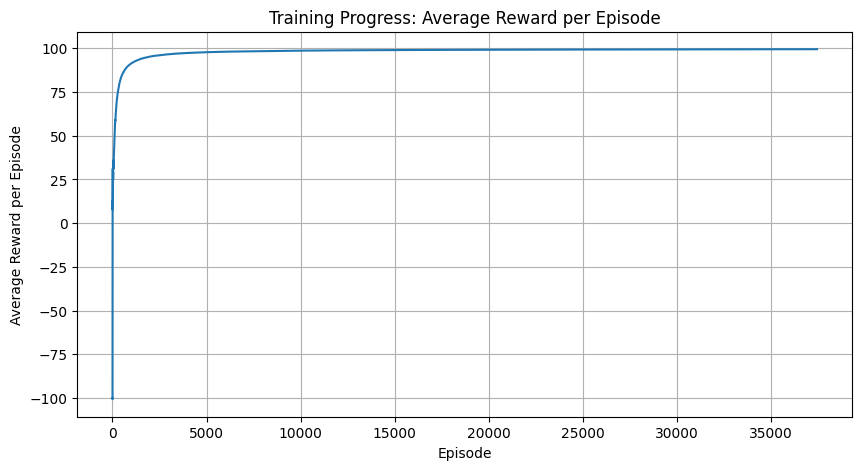

In [16]:
# PPO
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import PPO

class EpisodeRewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_count = 0

    def _on_step(self) -> bool:
        done = self.locals["dones"][0]
        if done:
            info = self.locals["infos"][0]
            # Get episode reward from info dict
            ep_rew = info.get("episode", {}).get("r")
            ep_len = info.get("episode", {}).get("l")
            if ep_rew is not None:
                self.episode_rewards.append(ep_rew)
                self.episode_lengths.append(ep_len)
                self.episode_count += 1
        return True

# env = DoubleGyreEnv()
env = DoubleGyreEnv(action_mode="continuous", randomize_params=True)
check_env(env)
model = PPO("MlpPolicy", env, verbose=1, batch_size=64)

callback = EpisodeRewardCallback()
model.learn(total_timesteps=1000000, callback=callback)
model.save("modelgyr")

# --- Plot average reward per episode ---
rewards = np.array(callback.episode_rewards)
episodes = np.arange(1, len(rewards) + 1)
avg_rewards = np.cumsum(rewards) / episodes

plt.figure(figsize=(10, 5))
plt.plot(episodes, avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Average Reward per Episode")
plt.title("Training Progress: Average Reward per Episode")
plt.grid(True)
plt.show()

The best Trajectory was for env number:4 it succeded in 17 steps and gainded reward of  100.8043952202736 and used 1.7000000000000004 energy!!
Success Rate: 98.00% (49/50 trajectories reached the goal)


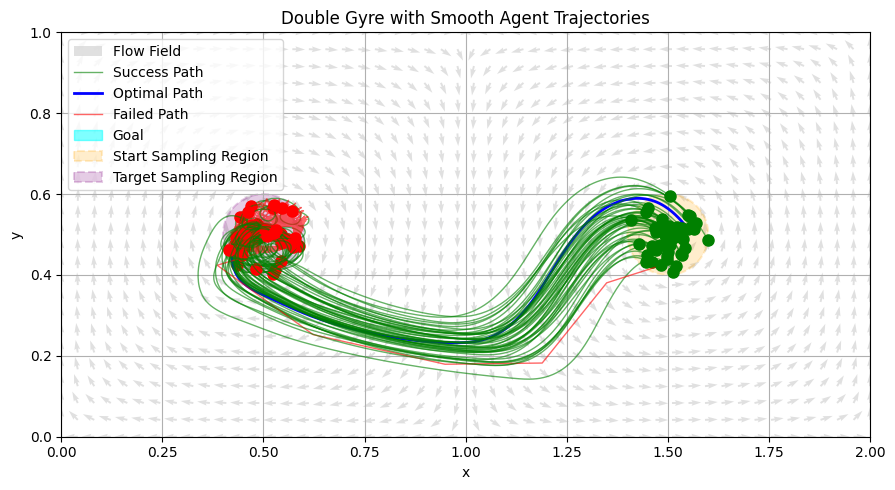

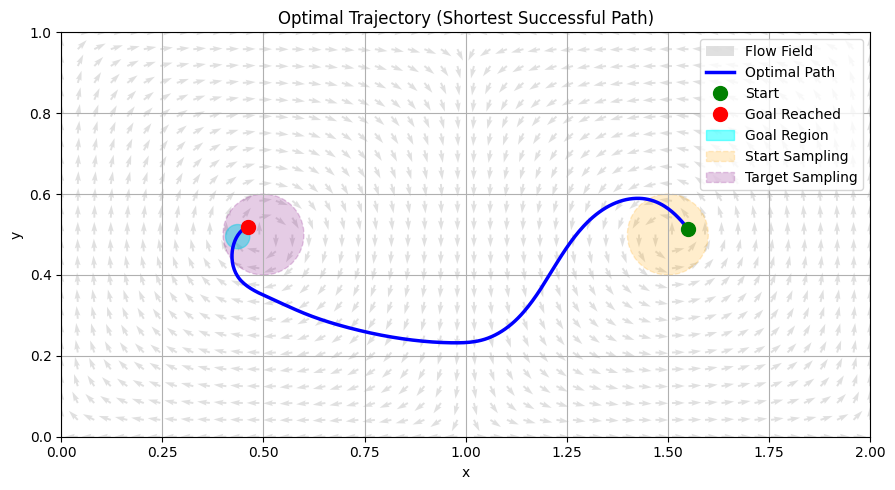

In [20]:
from scipy.interpolate import make_interp_spline

def plot_trajectories(envs, mode='human'):
    import matplotlib.pyplot as plt
    from scipy.interpolate import make_interp_spline
    import matplotlib.patches as patches
    import numpy as np

    plt.figure(figsize=(10, 5))
    env = envs[0]
    x_min, x_max = env.x_min, env.x_max
    y_min, y_max = env.y_min, env.y_max

    X, Y = np.meshgrid(np.linspace(x_min, x_max, 50),
                       np.linspace(y_min, y_max, 25))
    U = np.zeros_like(X)
    V = np.zeros_like(Y)

    t_plot = 0
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            u, v = env.velocity_field(X[i, j], Y[i, j], t_plot)
            U[i, j] = u
            V[i, j] = v

    norm = np.sqrt(U**2 + V**2)
    norm[norm == 0] = 1
    U_normalized = U / norm
    V_normalized = V / norm
    plt.quiver(X, Y, U_normalized, V_normalized, color='lightgray', alpha=0.7, label='Flow Field')

    success_count = 0
    total_traj = len(envs)

    # Determine successful and optimal environments
    successful_envs = []
    for env in envs:
        if env.successful_attempt:
            successful_envs.append(env)
            success_count+=1

    optimal_env = max(successful_envs, key=lambda e: e.total_return) if successful_envs else None

    for env in envs:
        traj = np.array(env.trajectory)
        # Determine color and label
        if env is optimal_env:
            print(f"The best Trajectory was for env number:{env.run_id} it succeded in {env.t} steps and gainded reward of  {env.total_return} and used {env.energy_used} energy!!")
            color = 'blue'
            label = 'Optimal Path'
            linewidth = 2
            alpha = 1.0
        else:
            color = 'green' if env.successful_attempt else 'red'
            label = 'Success Path' if env.successful_attempt else 'Failed Path'
            linewidth = 1
            alpha = 0.6

        # Smooth or straight plot
        if len(traj) > 3:
            t = np.linspace(0, 1, len(traj))
            t_fine = np.linspace(0, 1, 300)
            spl_x = make_interp_spline(t, traj[:, 0], k=3)
            spl_y = make_interp_spline(t, traj[:, 1], k=3)
            x_smooth = spl_x(t_fine)
            y_smooth = spl_y(t_fine)
            plt.plot(x_smooth, y_smooth, '-', color=color, label=label, linewidth=linewidth, alpha=alpha)
        else:
            plt.plot(traj[:, 0], traj[:, 1], '-o', color=color, label=label, markersize=3, linewidth=linewidth, alpha=alpha)

        plt.plot(traj[0, 0], traj[0, 1], 'go', markersize=8)
        plt.plot(traj[-1, 0], traj[-1, 1], 'ro', markersize=8)

    success_rate = (success_count / total_traj * 100) if total_traj > 0 else 0
    print(f"Success Rate: {success_rate:.2f}% ({success_count}/{total_traj} trajectories reached the goal)")

    goal = patches.Circle(env.goal_center, env.goal_radius, color='cyan', alpha=0.5, label='Goal')
    plt.gca().add_patch(goal)
    sample_circle = patches.Circle(env.right_flow_center, 0.1, color='orange', alpha=0.2, linestyle='--', linewidth=1.5, fill=True, label='Start Sampling Region')
    plt.gca().add_patch(sample_circle)
    target_sample_circle = patches.Circle(env.left_flow_center, env.goal_sphere_radius, color='purple', alpha=0.2, linestyle='--', linewidth=1.5, fill=True, label='Target Sampling Region')
    plt.gca().add_patch(target_sample_circle)

    plt.gca().set_aspect('equal')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Double Gyre with Smooth Agent Trajectories')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.tight_layout()

    if mode == 'human':
        plt.show()

    # === NEW PLOT: Optimal trajectory only ===
    if optimal_env is not None:
        traj = np.array(optimal_env.trajectory)

        plt.figure(figsize=(10, 5))
        X, Y = np.meshgrid(np.linspace(x_min, x_max, 50),
                           np.linspace(y_min, y_max, 25))
        U = np.zeros_like(X)
        V = np.zeros_like(Y)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                u, v = optimal_env.velocity_field(X[i, j], Y[i, j], t_plot)
                U[i, j] = u
                V[i, j] = v
        norm = np.sqrt(U**2 + V**2)
        norm[norm == 0] = 1
        plt.quiver(X, Y, U / norm, V / norm, color='lightgray', alpha=0.7, label='Flow Field')

        t = np.linspace(0, 1, len(traj))
        t_fine = np.linspace(0, 1, 300)
        spl_x = make_interp_spline(t, traj[:, 0], k=3)
        spl_y = make_interp_spline(t, traj[:, 1], k=3)
        x_smooth = spl_x(t_fine)
        y_smooth = spl_y(t_fine)

        plt.plot(x_smooth, y_smooth, '-', color='blue', linewidth=2.5, label='Optimal Path')
        plt.plot(traj[0, 0], traj[0, 1], 'go', markersize=10, label='Start')
        plt.plot(traj[-1, 0], traj[-1, 1], 'ro', markersize=10, label='Goal Reached')

        goal = patches.Circle(optimal_env.goal_center, optimal_env.goal_radius, color='cyan', alpha=0.5, label='Goal Region')
        plt.gca().add_patch(goal)
        sample_circle = patches.Circle(optimal_env.right_flow_center, 0.1, color='orange', alpha=0.2, linestyle='--', label='Start Sampling')
        plt.gca().add_patch(sample_circle)
        target_sample_circle = patches.Circle(optimal_env.left_flow_center, optimal_env.goal_sphere_radius, color='purple', alpha=0.2, linestyle='--', label='Target Sampling')
        plt.gca().add_patch(target_sample_circle)

        plt.gca().set_aspect('equal')
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Optimal Trajectory (Shortest Successful Path)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if mode == 'human':
            plt.show()

envs=[]
for i in range(50):
    env = DoubleGyreEnv(action_mode="continuous")
    check_env(env)
    obs, _ = env.reset(run_id=i)
    done = False
    env.history = [obs[:2]]
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        env.history.append(obs[:2])
    envs.append(env)
plot_trajectories(envs)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


The best Trajectory was for env number:0 it succeded in 15 steps and gainded reward of  100.9320107327257 and used 1.5000000000000002 energy!!
Success Rate: 97.60% (976/1000 trajectories reached the goal)


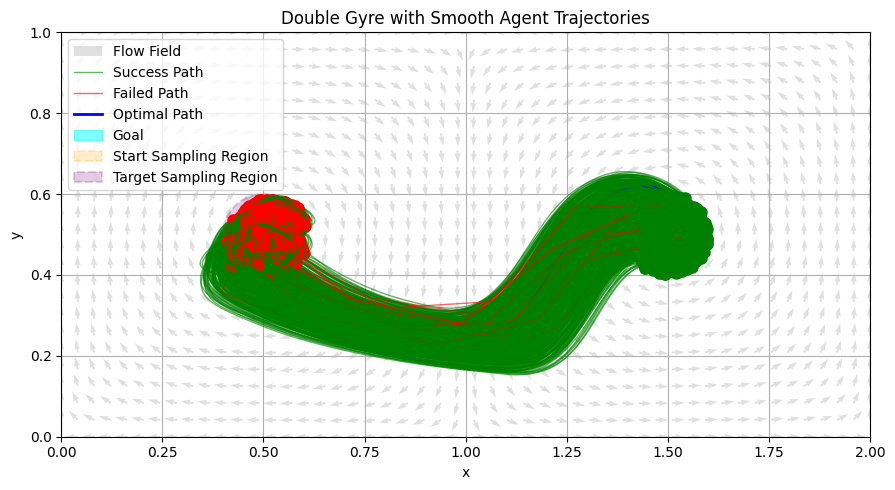

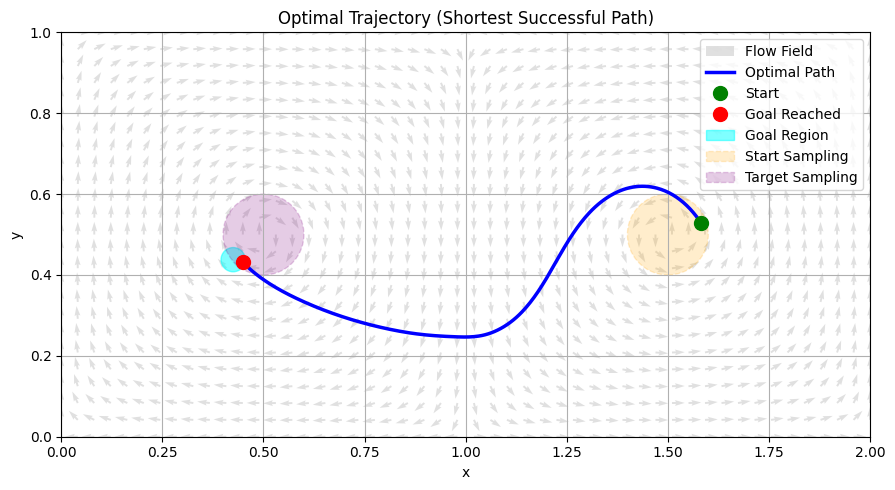

In [18]:
envs=[]
for i in range(1000):
    env = DoubleGyreEnv(action_mode="continuous")
    check_env(env)
    obs, _ = env.reset()
    done = False
    env.history = [obs[:2]]
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        env.history.append(obs[:2])
    envs.append(env)
plot_trajectories(envs)

In [22]:
import numpy as np

def path_length(traj):
    d = np.diff(np.array(traj), axis=0)
    return float(np.sum(np.linalg.norm(d, axis=1)))

def summarize(envs):
    succ = [e for e in envs if getattr(e, "successful_attempt", False)]
    fail = [e for e in envs if not getattr(e, "successful_attempt", False)]
    sr   = 100.0 * len(succ) / max(1, len(envs))
    steps = [e.t for e in succ]
    paths = [path_length(e.trajectory) for e in succ]
    energy= [e.energy_used for e in succ]
    return {
        "success_rate_%": sr,
        "steps_mean±std": (np.mean(steps), np.std(steps)),
        "path_len_mean±std": (np.mean(paths), np.std(paths)),
        "energy_mean±std": (np.mean(energy), np.std(energy)),
        "fail_count": len(fail)
    }

print("PPO test summary:", summarize(envs))  # use your 1000-episode list


PPO test summary: {'success_rate_%': 98.0, 'steps_mean±std': (np.float64(20.510204081632654), np.float64(6.411477110140915)), 'path_len_mean±std': (np.float64(1.525279258679577), np.float64(0.27837162324003506)), 'energy_mean±std': (np.float64(2.0510204081632657), np.float64(0.6411477110140916)), 'fail_count': 1}
